In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
dir='./dataset/'
no_tumor=os.listdir(dir+'no/')
yes_tumor=os.listdir(dir+'yes/')

In [4]:
import cv2
import numpy as np
from PIL import Image

In [5]:
dataset=[]
label=[]
for i, img_name in enumerate(no_tumor):
    if(img_name.split('.')[1]=='jpg'):
        img=cv2.imread(dir+'/no/'+img_name)
        img=Image.fromarray(img, 'RGB')
        img=img.resize((64,64))
        dataset.append(np.array(img))
        label.append(0)
for i, img_name in enumerate(yes_tumor):
    if(img_name.split('.')[1]=='jpg'):
        img=cv2.imread(dir+'/yes/'+img_name)
        img=Image.fromarray(img, 'RGB')
        img=img.resize((64,64))
        dataset.append(np.array(img))
        label.append(1)
        
dataset=np.array(dataset)
label=np.array(label)
print(len(dataset))
print(len(label))

3000
3000


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test=train_test_split(dataset, label, test_size=0.2, random_state=0)
print(X_train.shape)

(2400, 64, 64, 3)


In [8]:
from keras.utils import normalize, to_categorical
X_train=normalize(X_train, axis=1) #column
X_test=normalize(X_test, axis=1) #column

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, Layer,Add, MaxPooling2D,Activation, Dense, BatchNormalization, GlobalAveragePooling2D,Dropout,Flatten


In [10]:
# from keras import saving
# # Clear all previously registered custom objects
# keras.saving.get_custom_objects().clear()
#This is not lenet, my bad
# @saving.register_keras_serializable()
# class AlexNet(Model):
#     def __init__(self, **kwargs):
#         super(AlexNet, self,).__init__(**kwargs)
#         self.conv1=Conv2D(32,(3,3), input_shape=(64,64,3))
#         self.conv2=Conv2D(32,(3,3), kernel_initializer='he_uniform')
#         self.conv3=Conv2D(64,(3,3), kernel_initializer='he_uniform')
#         self.act=Activation('relu')
#         self.pool=MaxPooling2D(pool_size=(2,2))
#         self.flat=Flatten()
#         self.dense1=Dense(64)
#         self.drop=Dropout(0.5)
#         self.dense2=Dense(1)
#         self.end=Activation('sigmoid')
#     def call(self, x):
#         x=self.conv1(x)
#         x=self.act(x)
#         x=self.pool(x)
        
#         x=self.conv2(x)
#         x=self.act(x)
#         x=self.pool(x)
        
#         x=self.conv3(x)
#         x=self.act(x)
#         x=self.pool(x)
        
#         x=self.flat(x)
#         x=self.dense1(x)
#         x=self.act(x)
#         x=self.drop(x)
#         x=self.dense2(x)
#         x=self.end(x)

#         return x

In [41]:
#ResNet32
#Custom Conv2D
from keras import saving
@saving.register_keras_serializable()
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)
    
    self.batch_norm = BatchNormalization()

  def call(self, x):

    x = self.conv(x)
    x = self.batch_norm(x)

    return x
     
# Residual Block
@saving.register_keras_serializable()
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)
    
  def call(self, input):

    x = self.custom_conv_1(input)
    x = self.custom_conv_2(x)

    if self.dotted:
      x_add = self.custom_conv_3(input)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

     
# Complete Network

@saving.register_keras_serializable()
class ResNet34(Model):
  def __init__(self, **kwargs):
    super(ResNet34, self).__init__(**kwargs)
    
    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)
    
    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)
    
    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)
    
    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(1, activation = 'sigmoid')
    
  def call(self, x):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x)
    x = self.conv_2_2(x)
    x = self.conv_2_3(x)
    
    x = self.conv_3_1(x)
    x = self.conv_3_2(x)
    x = self.conv_3_3(x)
    x = self.conv_3_4(x)
    
    x = self.conv_4_1(x)
    x = self.conv_4_2(x)
    x = self.conv_4_3(x)
    x = self.conv_4_4(x)
    x = self.conv_4_5(x)
    x = self.conv_4_6(x)
    
    x = self.conv_5_1(x)
    x = self.conv_5_2(x)
    x = self.conv_5_3(x)

    x = self.global_pool(x)
    
    return self.fc_3(x)

In [42]:
Res=ResNet34()
Res.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'],)
history=Res.fit(x=X_train,y=y_train, 
            epochs=10, 
            batch_size=64, 
            verbose=1,
            validation_data=(X_test,y_test))

# save_model(Anet, './model/tumor_AN.h5')
# Anet.save_weights("./model/tumor_AN.weights.h5")
Res.save('./model/tumor_ResNetx64_sigmoid_BC_10epochs.keras')


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 37s 576ms/step - accuracy: 0.5014 - loss: 2.9282 - val_accuracy: 0.4950 - val_loss: 0.7150
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 625ms/step - accuracy: 0.5280 - loss: 0.6954 - val_accuracy: 0.6067 - val_loss: 0.6792
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 578ms/step - accuracy: 0.6931 - loss: 0.6117 - val_accuracy: 0.7017 - val_loss: 0.6022
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 571ms/step - accuracy: 0.7415 - loss: 0.5400 - val_accuracy: 0.6683 - val_loss: 0.6155
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 586ms/step - accuracy: 0.7889 - loss: 0.4866 - val_accuracy: 0.7917 - val_loss: 0.4895
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 597ms/step - accuracy: 0.8160 - loss: 0.4220 - val_accuracy: 0.7833 - val_loss: 0.4339
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 22s 586ms/step - accuracy: 0.8527 - loss: 0.3256 - val_accuracy: 0.8483 - val_loss: 0.3464
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 646ms/step - accuracy: 0.9003 - loss: 0.2442 - val_accu

In [43]:
from keras.models import load_model
model=load_model('./model/tumor_ResNetx64_sigmoid_BC_10epochs.keras')

In [44]:
import matplotlib.pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
there is no tumor


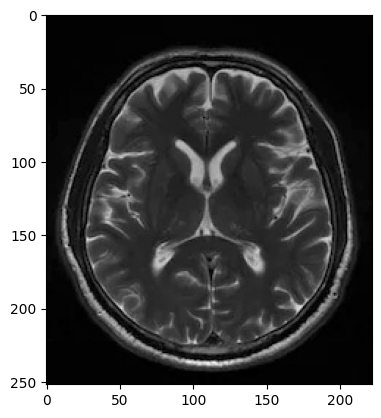

In [45]:
img = cv2.imread('./dataset/pred/pred29.jpg')
imgplot = plt.imshow(img)
img=Image.fromarray(img)
img=img.resize((64,64))
img=np.array(img)

input=np.expand_dims(img,axis=0)
input=tf.constant(input, dtype=tf.float32)
res=model.predict(input)
if(res==1):
    print('there is tumor')
else:
    print("there is no tumor")

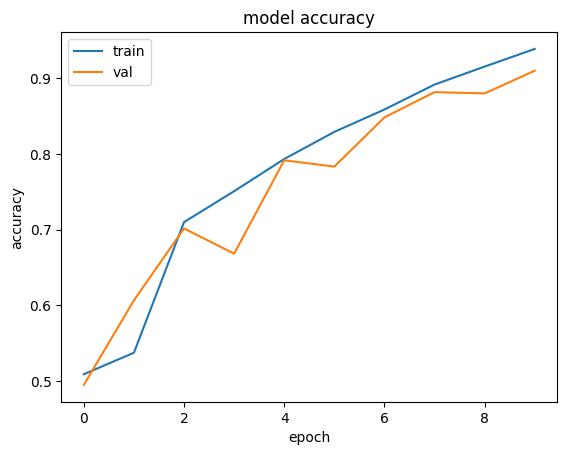

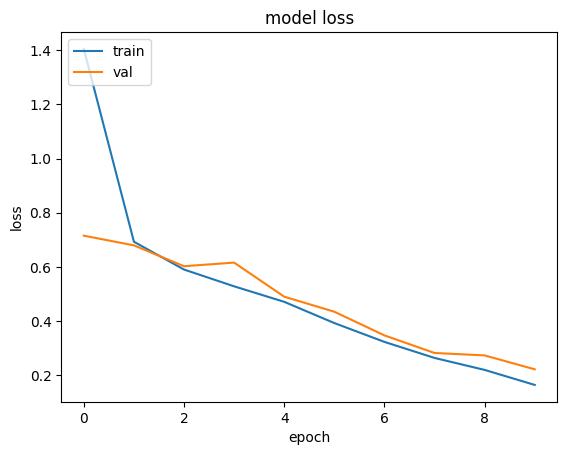

In [46]:
#acc
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()